In [7]:
import pandas as pd
from dateutil.parser import parse
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import clone
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition

import logging
import xgboost as xgb
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import patsy

% matplotlib inline

In [ ]:
df = pd.read_csv('Project_Luther_dataframe.csv')

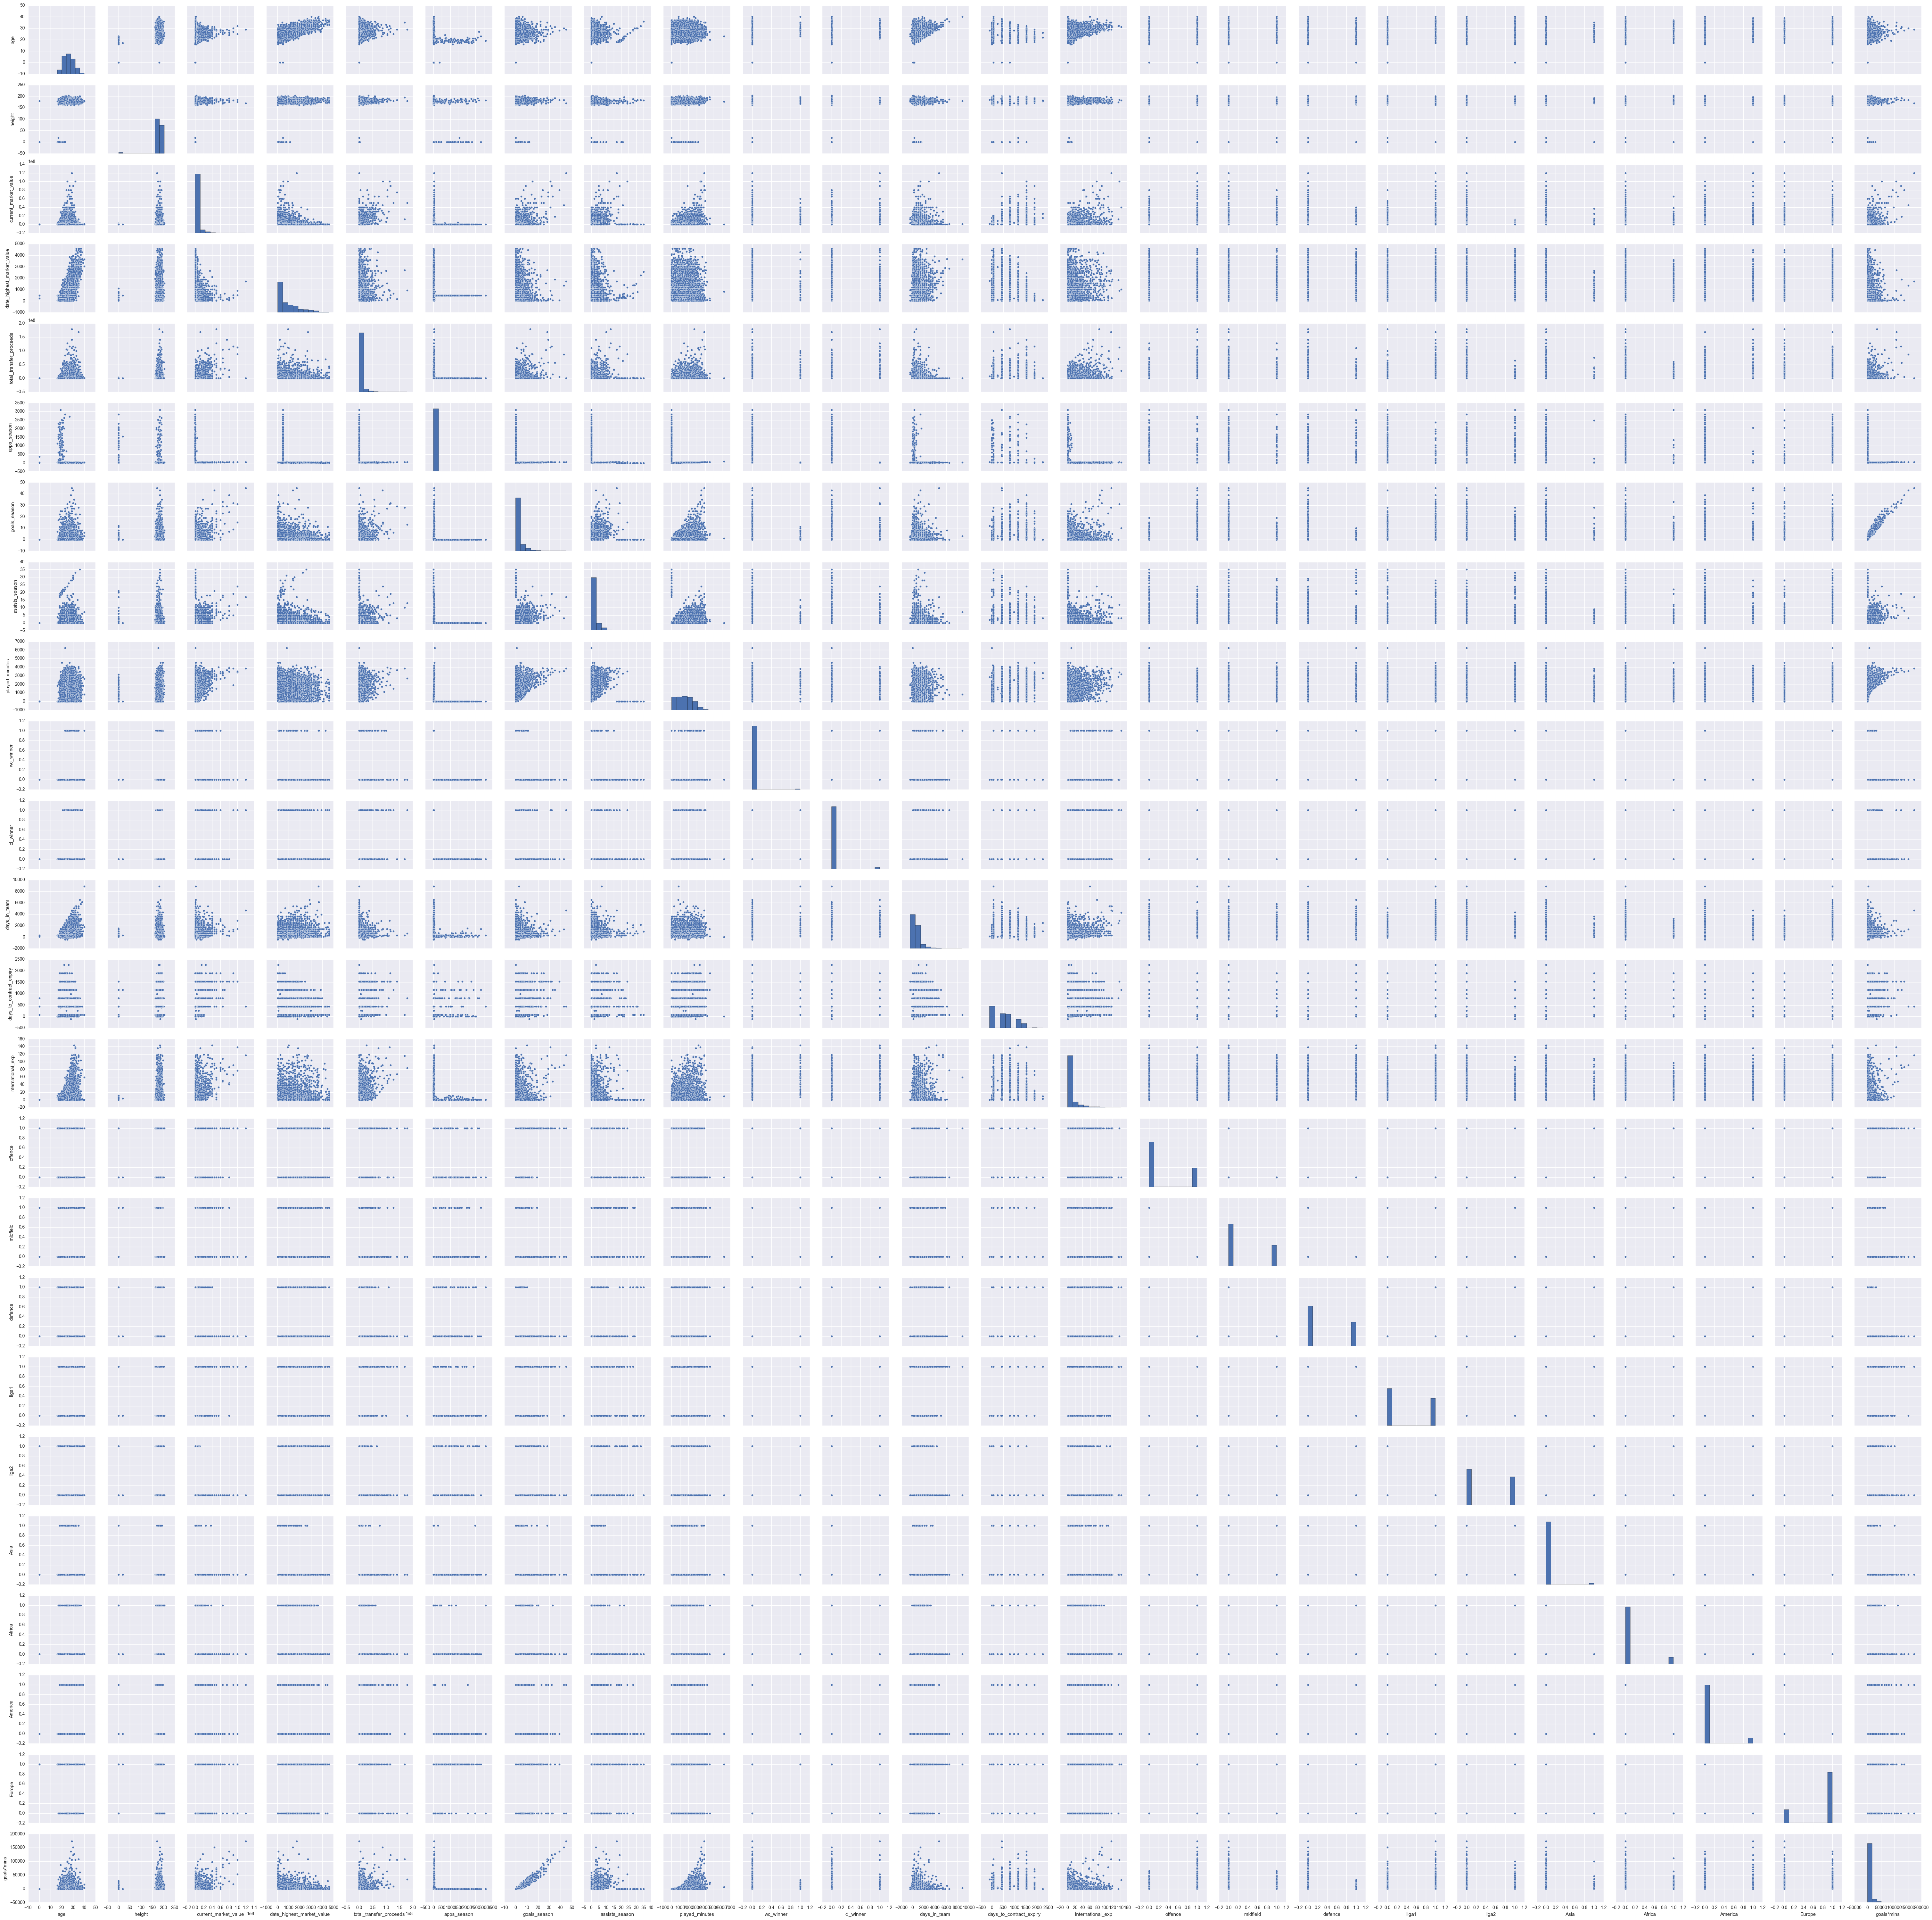

In [10]:
sns.pairplot(df)

In [ ]:
cols = ['age','offence','total_transfer_proceeds','apps_season','goals_season','assists_season', 'played_minutes',\
        'wc_winner','cl_winner','days_in_team','days_to_contract_expiry','international_exp','midfield',\
        'defence']
cols2 = ['age','total_transfer_proceeds','assists_season',\
        'cl_winner','days_in_team','days_to_contract_expiry','international_exp','liga1','goals*mins']
cols3 = ['age','total_transfer_proceeds','goals_season','assists_season', 'played_minutes',\
        'cl_winner','days_in_team','days_to_contract_expiry','international_exp','liga1']

X = df.loc[:,cols2]
y = df.loc[:, 'current_market_value']

In [680]:
holdout = df[(df['current_club'] == 'bayern munich')]
len(df),len(holdout)

(4662, 20)

In [4]:
# Create an empty model
lr = LinearRegression()
# Fit model
lr.fit(X, y)
# R^2 for lr model
lr.score(X,y)

0.60837475144415487

In [5]:
df.head()

name  age  height nationality   current_club  \
0  Jérôme Boateng   28     192     Germany  bayern munich   
1    Mats Hummels   28     191     Germany  bayern munich   
2   Javi Martínez   28     190       Spain  bayern munich   
3     David Alaba   24     180     Austria  bayern munich   
4     Juan Bernat   24     170       Spain  bayern munich   

   current_market_value  date_highest_market_value  total_transfer_proceeds  \
0              40000000                        274                 27100000   
1              38000000                        325                 39200000   
2              25000000                       1392                 46000000   
3              40000000                        554                   150000   
4              16000000                        661                 10000000   

   apps_season  goals_season     ...      offence  midfield  defence  liga1  \
0           17             0     ...            0         0        1      1   
1           39             2     ...            0         0        1      1   
2           35             1     ...            0         0        1      1   
3           41             3     ...            0         0        1      1   
4           20             3     ...            0         0        1      1   

   liga2  Asia  Africa  America  Europe  goals*mins  
0      0     0       0        0       1           0  
1      0     0       0        0       1        6098  
2      0     0       0        0       1        2795  
3      0     0       0        0       1        9996  
4      0     0       0        0       1        3966  

[5 rows x 27 columns]

### Statsmodels 
- Create feature matrix (X) and the target vector (y)

In [22]:
 model = smf.ols('current_market_value ~ liga1+age+total_transfer_proceeds+assists_season+played_minutes*goals_season+cl_winner+days_in_team+days_to_contract_expiry+international_exp', data=df)
# fit created model to training set
fit = model.fit()
# Summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     current_market_value   R-squared:                       0.622
Model:                              OLS   Adj. R-squared:                  0.621
Method:                   Least Squares   F-statistic:                     694.2
Date:                  Sat, 29 Apr 2017   Prob (F-statistic):               0.00
Time:                          09:47:21   Log-Likelihood:                -78354.
No. Observations:                  4662   AIC:                         1.567e+05
Df Residuals:                      4650   BIC:                         1.568e+05
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                     3.45e+06   4.78e+05      7.215      0.000      2.51e+06  4.39e+06
liga1                        1.428e+06   1.62e+05      8.832      0.000      1.11e+06  1.75e+06
age                         -2.389e+05   1.85e+04    -12.933      0.000     -2.75e+05 -2.03e+05
total_transfer_proceeds         0.2815      0.008     36.827      0.000         0.267     0.297
assists_season                2.21e+05   2.63e+04      8.408      0.000      1.69e+05  2.73e+05
played_minutes                383.8632     88.713      4.327      0.000       209.943   557.783
goals_season                -6.701e+05   5.98e+04    -11.207      0.000     -7.87e+05 -5.53e+05
played_minutes:goals_season   392.7003     21.916     17.918      0.000       349.735   435.666
cl_winner                    4.169e+06   5.06e+05      8.243      0.000      3.18e+06  5.16e+06
days_in_team                 1379.9075    105.516     13.078      0.000      1173.046  1586.769
days_to_contract_expiry      2319.1623    167.747     13.825      0.000      1990.299  2648.025
international_exp              5.5e+04   4940.600     11.133      0.000      4.53e+04  6.47e+04
==============================================================================
Omnibus:                     2553.161   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           182270.657
Skew:                           1.784   Prob(JB):                         0.00
Kurtosis:                      33.424   Cond. No.                     9.03e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

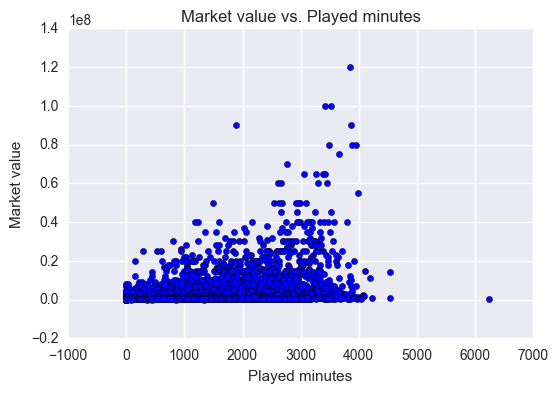

In [15]:
plt.scatter(df['played_minutes'], df['current_market_value'])
plt.ylabel('Market value')
plt.xlabel('Played minutes')
plt.title('Market value vs. Played minutes')

### Linear models

In [ ]:
def scale(x,y):
    X = preprocessing.robust_scale(x)
    y = preprocessing.robust_scale(y)
    return X,y

In [ ]:
cols = ['age','total_transfer_proceeds','apps_season',\
               'goals_season','assists_season','minute_per_goal', 'played_minutes',\
               'wc_winner','cl_winner','days_in_team','days_to_contract_expiry']

def run_linear_models(x,y)
    '''Get an overview of performances of different linear models.
    Linear models: Linear Regression, Ridge, 3x Lasso, ElasticNet'''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    lr = LinearRegression()
    rd = Ridge()
    las2 = Lasso(alpha=0.00001)
    las1 = Lasso(alpha=.0001)
    las = Lasso(alpha=.001)
    en = ElasticNet()

    models = [lr,rd,las2,las1,las,en]

    for model in models:
        model.fit(X_train,y_train)
        sorted_features = sorted(zip(cols,model.coef_))
        
        print('Model: ' + str(model)[:25])
        print("Score: " + str(model.score(X_test,y_test)))    
        for feature in sorted_features:
            print(feature)
        print("")

In [19]:
run_linear_models(X,y)

Model: LinearRegression(copy_X=T
Score: 0.637309734461
('age', -205499.00430375832)
('apps_season', 4316482.5926728714)
('assists_season', 2388.3601872969816)
('cl_winner', 185.70388237431956)
('goals_season', 1558.3231744654174)
('offence', 0.25452251969234913)
('played_minutes', 58538.622196403114)
('total_transfer_proceeds', 204631.2731136315)
('wc_winner', 1309612.6453310458)

Model: Ridge(alpha=1.0, copy_X=T
Score: 0.637319669608
('age', -205527.23645230519)
('apps_season', 4246309.8097762931)
('assists_season', 2389.0171183788507)
('cl_winner', 185.65203290704372)
('goals_season', 1560.1956916243573)
('offence', 0.25469129950293495)
('played_minutes', 58693.385138931546)
('total_transfer_proceeds', 204662.84413626848)
('wc_winner', 1308010.5772865952)

Model: Lasso(alpha=1e-05, copy_X
Score: 0.637309734461
('age', -205499.00430314199)
('apps_season', 4316482.5921392543)
('assists_season', 2388.360187316252)
('cl_winner', 185.70388237300256)
('goals_season', 1558.3231744773418)
('

In [125]:
def run_tree_models(x,y):
    '''Get an overview of performances of different tree models.
    Tree models: Decision tree, AdaBoost, Bagged tree'''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    dt = DecisionTreeRegressor()
    dt.fit(X_train, y_train)
    print('Decision Tree Score: ' + str(dt.score(X_test, y_test)))

    ada = AdaBoostRegressor(LinearRegression())
    ada.fit(X_train, y_train)
    print('AdaBoost Regressor Score: ' + str(ada.score(X_test, y_test)))

    # Train and Score Bagged Tree Regressor (ensemble learner)
    bagged_tree = BaggingRegressor(DecisionTreeRegressor())
    bagged_tree.fit(X_train, y_train)
    print('Bagged Tree Score: ' + str(bagged_tree.score(X_test, y_test)))
    

Decision Tree Score: 0.414660688058
AdaBoost Regressor Score: 0.348984844331
Bagged Tree Score: 0.694181262302


### Random Forest

In [ ]:
def random_forest(X, y,n_est):
    '''Run a random forest model.'''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    rfc = RandomForestRegressor(n_estimators=n_est)
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std
    clf = clone(rfc)
    clf = rfc.fit(X_train, y_train)

    scores = clf.score(X_test, y_test)

    return 'Random Forest Score: '+str(scores), dict(zip(cols2, clf.feature_importances_))

#### Run random forest model with different numbers of estimators as a parameter.

In [126]:
for i in [10,30,50,100,200,300]:
    print(random_forest(X,y,i))

('Random Forest Score: 0.627371242138', {'assists_season': 0.081514476885539783, 'liga1': 0.017833612580371715, 'age': 0.055600275956012038, 'days_to_contract_expiry': 0.068498034259292725, 'total_transfer_proceeds': 0.43845444234457309, 'international_exp': 0.050832097797877729, 'days_in_team': 0.064985147889509348, 'wc_winner': 0.0184060679619104, 'cl_winner': 0.0086529611786186882, 'goals*mins': 0.19522288314629441})
('Random Forest Score: 0.617268748185', {'assists_season': 0.076094869912526356, 'liga1': 0.020545129438966959, 'age': 0.059900122356240003, 'days_to_contract_expiry': 0.044274908111713196, 'total_transfer_proceeds': 0.52412406487130869, 'international_exp': 0.044668750889650104, 'days_in_team': 0.070938388423268744, 'wc_winner': 0.013858404064692013, 'cl_winner': 0.0059520023460904598, 'goals*mins': 0.13964335958554333})
('Random Forest Score: 0.760067140377', {'assists_season': 0.075045465826273791, 'liga1': 0.021047304786156219, 'age': 0.061479078365499332, 'days_to_

### Extra Trees

In [ ]:
def extra_trees(X,y,n_est):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    ext = ExtraTreesRegressor(n_estimators=n_est)
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std
    clf = clone(ext)
    clf = ext.fit(X_train, y_train)

    scores = ext.score(X_test, y_test)

    return 'ExtraTrees Score: '+str(scores), dict(zip(cols2, clf.feature_importances_))

#### Run ExtraTrees model with different numbers of estimators as a parameter.

In [157]:
for i in [10,30,50,100,200,300]:
    print(extra_trees(X,y,i))

('ExtraTrees Score: 0.660371973646', {'assists_season': 0.090421320122152163, 'liga1': 0.059980313990751752, 'age': 0.054280508246166939, 'days_to_contract_expiry': 0.099128994543887822, 'total_transfer_proceeds': 0.32332127590684939, 'international_exp': 0.077564323912244715, 'days_in_team': 0.058874263319795374, 'goals*mins': 0.19055601051274665, 'cl_winner': 0.045872989445405181})
('ExtraTrees Score: 0.733264267347', {'assists_season': 0.09982959242871832, 'liga1': 0.081161571579647998, 'age': 0.05659628041362616, 'days_to_contract_expiry': 0.07617852856170855, 'total_transfer_proceeds': 0.29755302724264304, 'international_exp': 0.065478867734479682, 'days_in_team': 0.073738324319527898, 'goals*mins': 0.21723629671129613, 'cl_winner': 0.032227511008352375})
('ExtraTrees Score: 0.740234229341', {'assists_season': 0.064183311884336444, 'liga1': 0.069233993811734659, 'age': 0.061767062635740742, 'days_to_contract_expiry': 0.10349867436162785, 'total_transfer_proceeds': 0.36475242332217

### Polynomial Random Forest

#### Create a pipeline using Random forest with polynomial features.

In [5]:
def poly_rf(x,y,degree):
    dgr = degree
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    est = make_pipeline(PolynomialFeatures(dgr),RandomForestRegressor(n_estimators=200,max_features='auto',min_samples_split=10))
    est.fit(X_train,y_train)
    print('Scores:',est.score(X_test,y_test))

In [14]:
poly_rf(X,y,3)

0.74158642995474144

### Gradient Boosting

In [ ]:
def gbr(n_est):
    gbr = GradientBoostingRegressor(n_estimators = n_est,max_features=3, 
                                         learning_rate = .15,
                                        max_depth = 2,min_samples_leaf=8, alpha=.5)
    gbr.fit(X_train,y_train)
    return gbr.score(X_test,y_test)

#### Run gradient boosting with different number of estimators.

In [27]:
for i in [10,30,50,100,200,300]:
    print(gbr(i))

0.458429804548
0.645562719939
0.702509367056
0.756436441068
0.776889633371
0.786098039751


### XGB Regressor

In [24]:
model_xgb = xgb.XGBRegressor(n_estimators=200,learning_rate=0.15,max_depth=2)
model_xgb.fit(X_train, y_train, eval_metric='rmse')
model_xgb.score(X_test,y_test)

0.79037152508910857

### Find optimal parameters for Gradient Boosting model
#### Graph performance with different values for parameters.

In [17]:
def plot_overfit(X,y,model_obj,param_ranges,param_static=None): 
    for parameter,parameter_range in param_ranges.items():
        avg_train_score, avg_test_score = [],[]
        std_train_score, std_test_score = [],[]
        
        for param_val in parameter_range:
            param = {parameter:param_val}
            if param_static:
                param.update(param_static)
                
            model = model_obj(**param)
            
            train_scores,test_scores = [],[]
            for i in range(5):
                X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size = .3)
                model.fit(X_train,y_train)
                
                train_scores.append(model.score(X_train,y_train))
                test_scores.append(model.score(X_test,y_test))
            
            avg_train_score.append(np.mean(train_scores))
            avg_test_score.append(np.mean(test_scores))
            
            std_train_score.append(np.std(train_scores))
            std_test_score.append(np.std(test_scores))
            
        fig,ax = plt.subplots()
        ax.errorbar(parameter_range,avg_train_score,yerr=std_train_score,label='training score')
        ax.errorbar(parameter_range,avg_test_score,yerr=std_test_score,label='testing score')
        
        ax.set_xlabel(parameter)
        ax.set_ylabel('score')
        ax.legend(loc=0)

/Users/flowinger/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


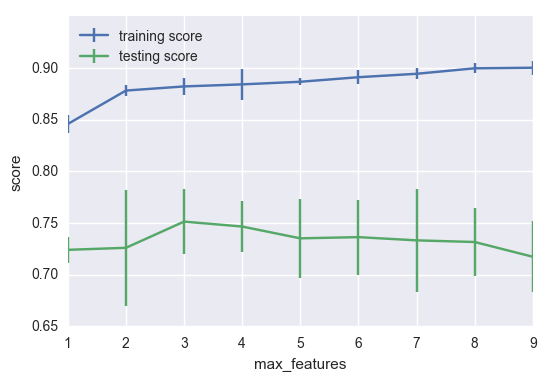

In [33]:
plot_overfit(X,y,GradientBoostingRegressor,{'max_features':range(1,10)})

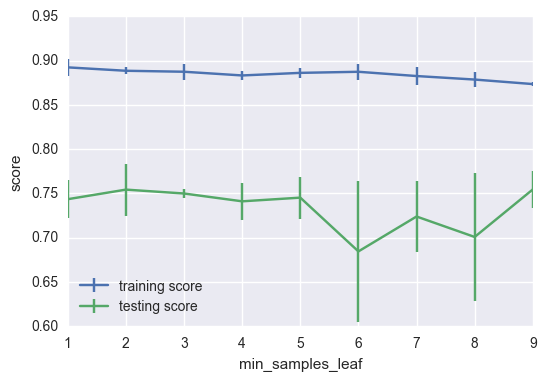

In [34]:
plot_overfit(X,y,GradientBoostingRegressor,{'min_samples_leaf':range(1,10)})

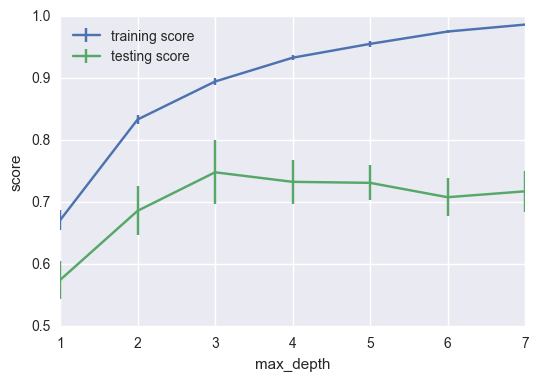

In [35]:
plot_overfit(X,y,GradientBoostingRegressor,{'max_depth':range(1,8)})

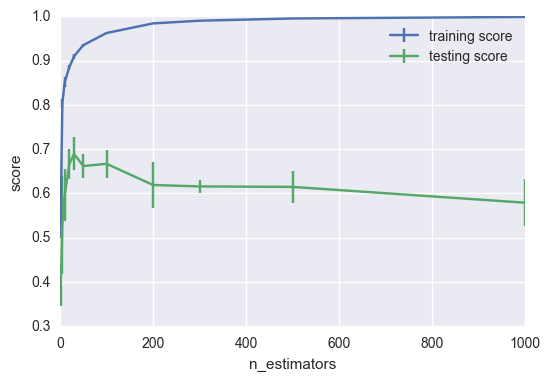

In [36]:
plot_overfit(X,y,GradientBoostingRegressor,{'n_estimators':[1,5,10,20,30,50,100,200,300,500,1000]},param_static={'learning_rate':.75})

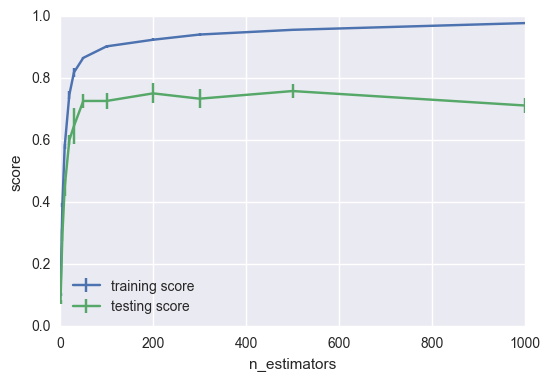

In [37]:
plot_overfit(X,y,GradientBoostingRegressor,{'n_estimators':[1,5,10,20,30,50,100,200,300,500,1000]})

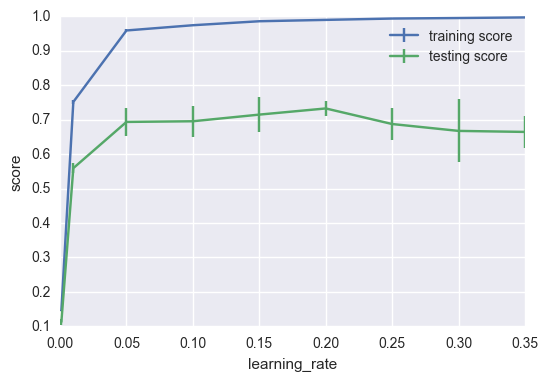

In [38]:
model = GradientBoostingRegressor
params = {'learning_rate':[.001,.01,.05,.1,.15,.2,.25,.3,.35,]}
param_static = {'max_depth':6}
plot_overfit(X,y,model,params,param_static=param_static)

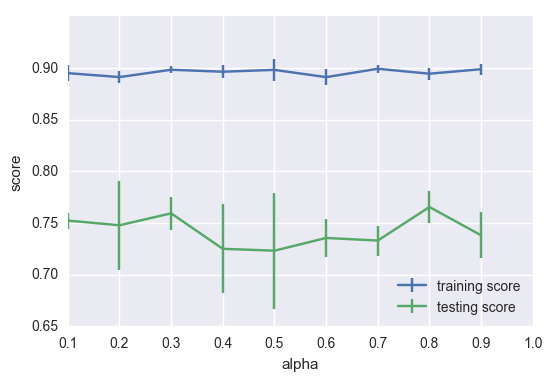

In [16]:
plot_overfit(X,y,GradientBoostingRegressor,{'alpha':np.arange(.1,1,.1)})

### Regression pipeline

In [40]:
def regression_pipeline(x,y,degree,pca_comps):
    # lets try using some feature tranforms, to our original X
    combined_features = pipeline.FeatureUnion([('poly',PolynomialFeatures(degree=degree)),
                                              ('pca', decomposition.PCA(n_components=pca_comps))])
    X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = .3)
    
    # now lets lay out the steps of our model
    # First we do the feature transforms with our feature union defined above
    # Second we do feature selection with the built-in SelectFromModel
    # Third we train the actual model
    steps = [
    ('features', combined_features),
    ('feature_selection', feature_selection.SelectFromModel(Lasso(alpha=.5))),
    ('model', LinearRegression())]

    #but at this point we have only defined what reg, no training has happened yet
    regression_pipeline = pipeline.Pipeline(steps)
    # calling fit here calls fit on the entire pipeline which in turn executes all its members
    regression_pipeline.fit(X_train,y_train)
    # calling score/predict will call fit then transform on each object in the pipeline
    print(regression_pipeline.score(X_test,y_test))


/Users/flowinger/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.82224724783830561

### GridSearch CV

In [41]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

parameters = {
    'features__poly__degree': (2,3,4),
    'features__pca__n_components': (2,3,4),
}

grid_search = GridSearchCV(regression_pipeline, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/flowinger/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/flowinger/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/flowinger/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/flowinger/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objectiv

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))],
       transformer_we...old=None)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=-2,
       param_grid={'features__poly__degree': (2, 3, 4), 'features__pca__n_components': (2, 3, 4)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [42]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.735
Best parameters set:
	features__pca__n_components: 2
	features__poly__degree: 2


### Calculate RMSE for each model

In [44]:
### Random Forest
rfmodel1 = RandomForestRegressor(n_estimators = 100, max_features = 3,
                                min_samples_leaf = 4, n_jobs=4)
rfmodel1.fit(X_train,y_train)
pred_vals_rf1 = rfmodel1.predict(X_test)
RMSE_rf1 = np.sqrt(np.sum((pred_vals_rf1 - y_test)**2)/len(y_test))
RMSE_rf1

4375644.7022164743

In [45]:
sorted(zip(X.columns,abs(rfmodel1.feature_importances_)), key=lambda x: -x[1])

[('total_transfer_proceeds', 0.31895516922262529),
 ('goals*mins', 0.20643201623482746),
 ('international_exp', 0.12757225309845052),
 ('assists_season', 0.096284781737473624),
 ('days_to_contract_expiry', 0.082249958681318708),
 ('days_in_team', 0.056264082993439456),
 ('age', 0.049480625546337788),
 ('liga1', 0.04444618129094783),
 ('cl_winner', 0.018314931194579286)]

### Predictions

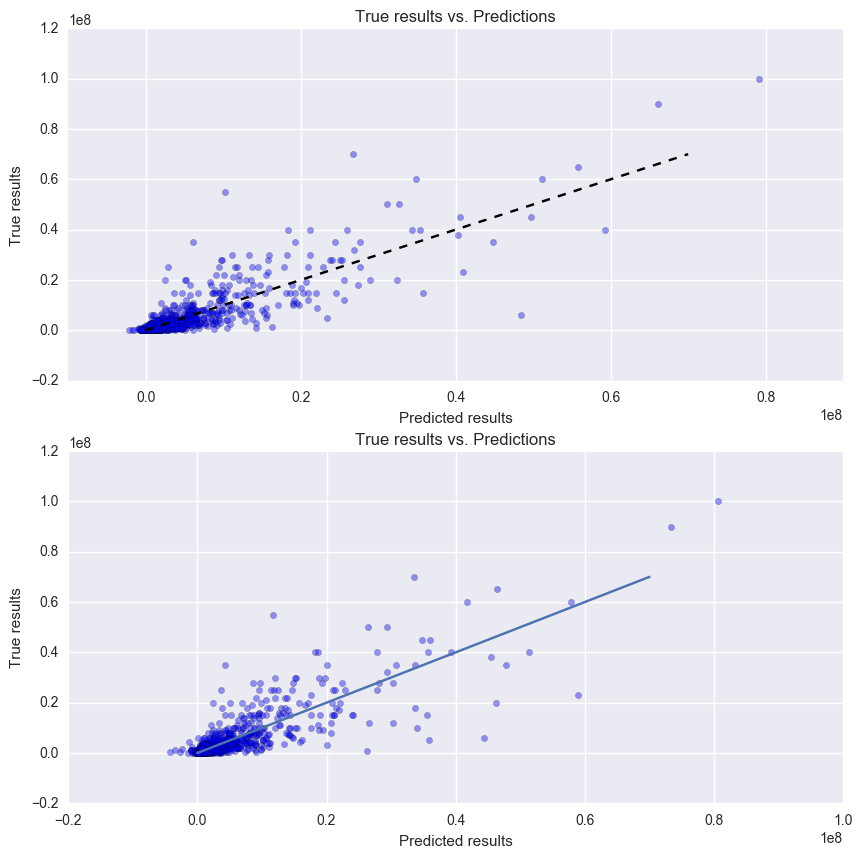

In [100]:
plt.figure(figsize=(10, 10))

val = np.linspace(0,70000000,10)

plt.subplot(2, 1, 1)
plt.scatter(pred_vals_gb1,y_test, alpha = .4)
plt.plot(val,val,'k--')
plt.title('True results vs. Predictions')
plt.xlabel('Predicted results')
plt.ylabel('True results')

plt.subplot(2, 1, 2)
plt.scatter(pred_vals_gb2,y_test, alpha = .4)
plt.plot(val,val)
plt.title('True results vs. Predictions')
plt.xlabel('Predicted results')
plt.ylabel('True results')



### Prediction to holdout set

In [13]:
#df.to_csv('0426_2243pm.csv',index=False)
test = pd.read_csv('results_0427.csv')
test

Name  Current market value  Predictions
0   Robert Lewandowski                  80.0         48.9
1        Thomas Müller                  60.0         42.8
2               Thiago                  40.0         22.1
3       Jérôme Boateng                  40.0         32.6
4          David Alaba                  40.0         34.8
5         Mats Hummels                  38.0         20.8
6         Arturo Vidal                  37.0         23.2
7       Renato Sanches                  30.0         24.1
8        Douglas Costa                  30.0         23.5
9       Joshua Kimmich                  25.0         10.9
10       Javi Martínez                  25.0         26.0
11      Kingsley Coman                  20.0          5.9
12         Juan Bernat                  16.0          8.2
13        Philipp Lahm                  11.0         21.4
14        Arjen Robben                  10.0         24.2
15       Franck Ribéry                   8.0         14.0
16             Rafinha                   5.0          4.4
17         Xabi Alonso                   3.5         -6.4
18       Niklas Dorsch                   0.2          0.7
19        Fabian Benko                   0.2          0.2

### Additional data exploration

0 age
1 total_transfer_proceeds
2 goals_season
3 assists_season
4 played_minutes
5 cl_winner
6 days_in_team
7 days_to_contract_expiry
8 international_exp
9 liga1
10 liga2


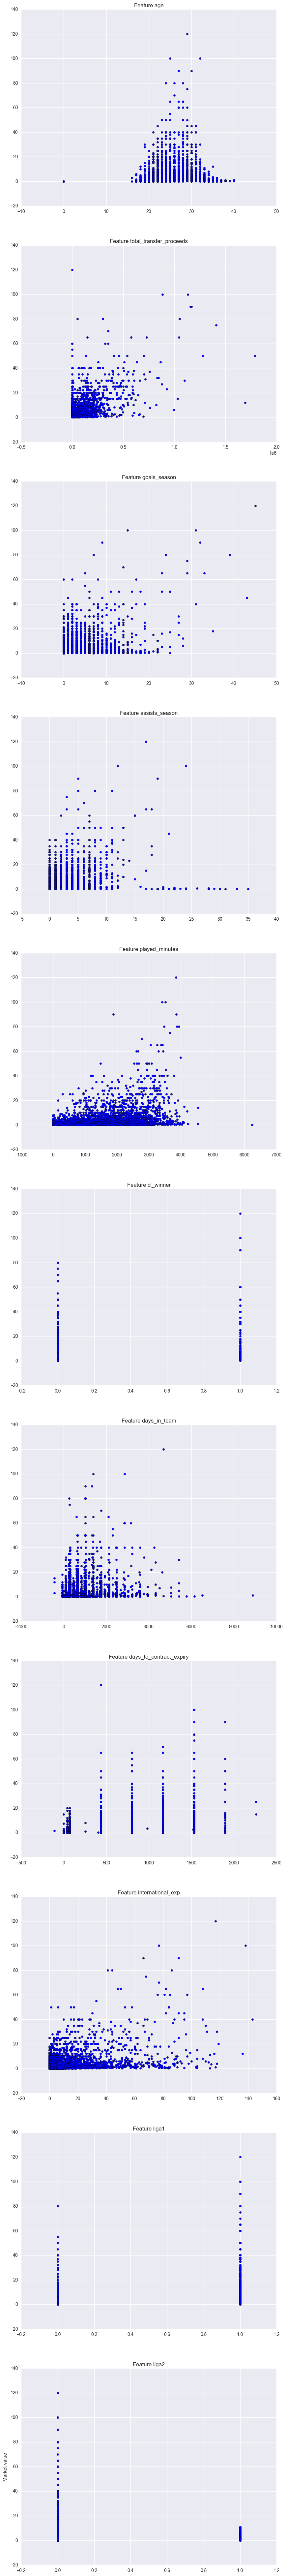

In [340]:
fig,ax = plt.subplots(ncols=1,nrows=len(test.columns),figsize=(10, 100))

for i,feature in enumerate(test):
    print(i,feature)
    ax[i].scatter(test[feature],y/1000000)
    ax[i].set_title("Feature "+str(feature))
    plt.ylabel('Market value')

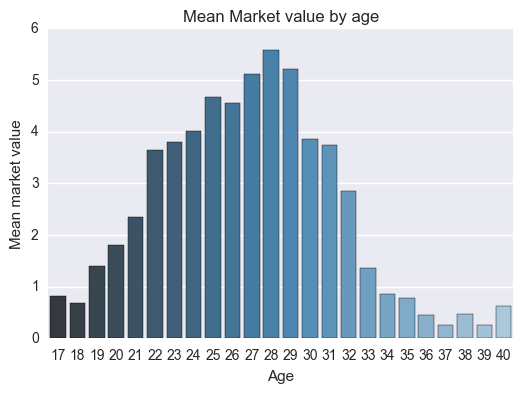

In [7]:
sns.barplot(df[df['age'] > 16]['age'],df[df['age'] > 16]['current_market_value']/1000000,palette='Blues_d',ci=None)
plt.ylabel('Mean market value')
plt.xlabel('Age')
plt.title('Mean Market value by age')

In [8]:
rng = np.arange(len(df[df['current_market_value']>10000000]))
len(df[df['current_market_value']>10000000])-1,len(np.arange(len(df[df['current_market_value']>10000000])-1))
d = df[df['current_market_value']>10000000]
c = df[df['current_market_value']>20000000]
f = df[df['current_market_value']<10000000]
len(d['current_market_value'])

386

In [9]:
from sklearn.utils import shuffle
d = shuffle(d)
f = shuffle(f)
c = shuffle(c)

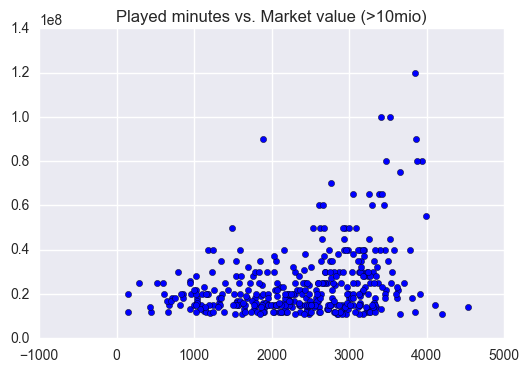

In [10]:
plt.scatter(d['played_minutes'],d['current_market_value'])
plt.title('Played minutes vs. Market value (>10mio)')

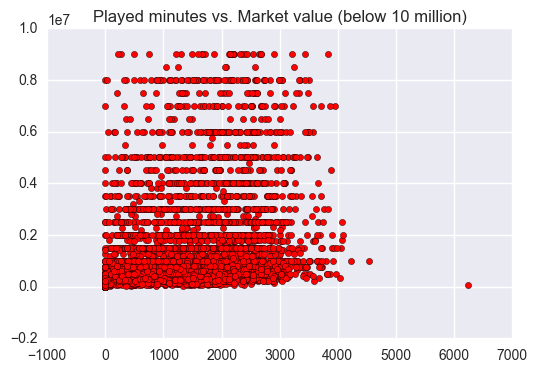

In [11]:
plt.scatter(f['played_minutes'],f['current_market_value'], c='red')
plt.title('Played minutes vs. Market value (below 10 million)')

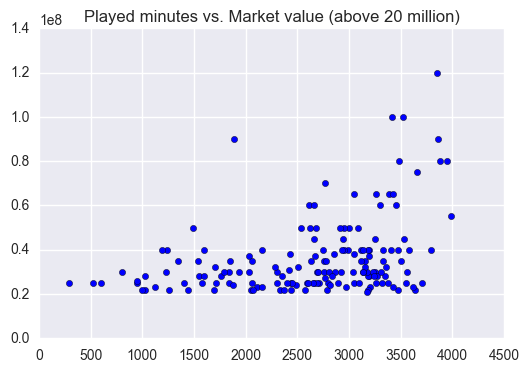

In [12]:
plt.scatter(c['played_minutes'],c['current_market_value'])
plt.title('Played minutes vs. Market value (above 20 million)')